## Feature extraction example

In the main lectures we have covered the basic of recurrent architectures, what their components are, and how to train them. In this tutorial we will focus on what actually goes _into_ these networks when we do audio processing.

We start by importing the necessary modules, especially the `librosa` package we will be using extensively.

In [0]:
%matplotlib inline
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from scipy.io import wavfile
from scipy.fftpack import dct, idct, ifft
import matplotlib.pyplot as plt

We first load a few examples we're going to be using for this tutorial. Any wav file will do.

The ones I've used when designing this tutorial are a few examples from the Speech Commands dataset, and can be found in http://www.doc.ic.ac.uk/~pam213/co460_files .

In [0]:
# These are three wav files with 1s recordings of a man and a woman saying
# the words 'happy' and 'yes'. hm,yf,ym are the raw waveforms and sr is their
# sampling rate (which we know is 16k Hz for all samples in the dataset).
hm = wavfile.read('happy_male.wav')[1]
yf = wavfile.read('yes_female.wav')[1]
sr, ym = wavfile.read('yes_male.wav')

# Typically waveforms are normalised by their max value
ym = ym/ym.max()
yf = yf/yf.max()
hm = hm/hm.max()

Now we can listen to our audio files from Colab:

In [0]:
Audio(hm, rate=sr)

And we can use `librosa` (or `matplotlib`, really) to visualise the raw waveforms.

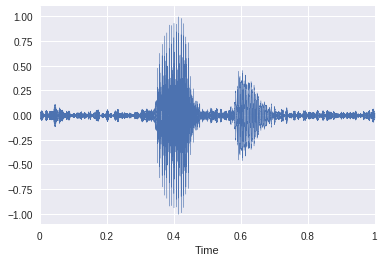

In [5]:
librosa.display.waveplot(y=hm, sr=sr)

Just by looking at the raw waveforms we can recognise a few salient features of the audio, like silence vs speech, rough segmentation of phonemes, etc.

Text(0.5, 1.0, "'Yes'")

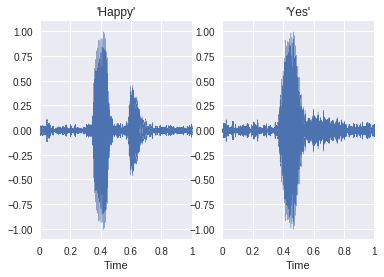

In [0]:
plt.subplot(1,2,1)
librosa.display.waveplot(y=hm, sr=sr)
plt.title('\'Happy\'')
plt.subplot(1,2,2)
librosa.display.waveplot(y=ym, sr=sr)
plt.title('\'Yes\'')

The problem is, the waveforms above have _a lot_ of numbers. That's 16000 numbers to work with, and this is a short segment of heavily downsampled audio (standard audio sampling rates are around the 44-48k Hz).

As you probably know, a pretty useful summary of the content of a signal is given by its power spectrum. Using the Fourier transform we can extract the frequency components of our signal, which are typically already much more informative than the raw waveform.

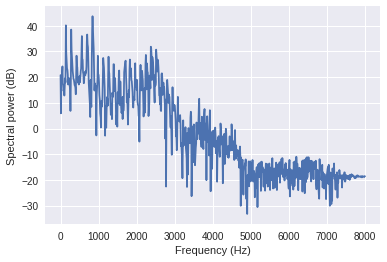

In [6]:
# In the happy_male.wav, you can try:
# 0.05 - 0.15 for background noise
# 0.35 - 0.45 for the first syllable
# 0.60 - 0.70 for the second syllable
start = int(0.35*sr)
end = int(0.45*sr)
psd = np.abs(np.fft.fft(hm[start:end]))**2
psd = psd[0:len(psd)//2]  # Take only the first half of the spectrum
plt.plot(np.linspace(0, sr/2, len(psd)), 10*np.log10(psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral power (dB)')
plt.show()

So, this is a simple way of obtaining some audio features: split the signal into windows, and then compute the power spectrum of these windows. In the audio processing literature, these windows are called _audio frames_. If we take the concated spectra of all frames we get our first set of audio features: the **spectrogram**. Technically, we do this via the _Short-Time Fourier Transform_ (STFT).

This is where `librosa` jumps in -- computing the STFT usually involves tricky manipulations of subarrays, windows, boundary conditions, and numerically unstable logs. Let's use the library to inspect the spectrogram of our signals. In particular, there are two components that will come in handy for ML post-processing:

- `n_fft`, the number of components of the short-time window.
- `hop_length`, the shift between two consecutive windows.

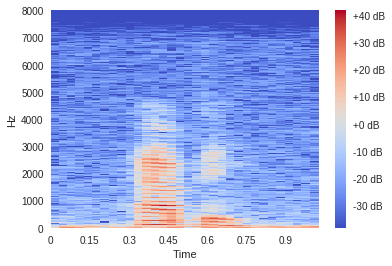

In [7]:
n_fft = 2048
hop_length = 512
u = np.abs(librosa.stft(hm, n_fft=n_fft, hop_length=hop_length))
librosa.display.specshow(librosa.amplitude_to_db(u), hop_length=hop_length, sr=sr, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')

That's an improvement over using the raw waveform. However, in these 'naive' spectrograms there's still a lot of nearly useless information. Notice how, even during speech, there's nothing in frequencies higher than ~5000 Hz.

To alleviate this problem we can introduce the _mel scale_: a transformation of frequencies based on human audition that has higher resolution for frequencies more easily perceived by humans. We can transform between frequencies and mel scale using the _mel filters_ (or the _mel filter bank_), also available in `librosa`.

Text(0.5, 0, 'Frequency')

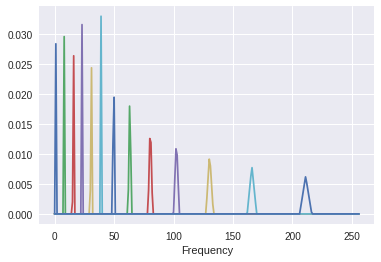

In [0]:
mels = librosa.filters.mel(sr, 512)
for j in range(0, mels.shape[0], 10):
  plt.plot(mels[j,:])
plt.xlabel('Frequency')

If we plot the location of the peaks of these filters we get the _mel curve_, which is essentially a normalised logarithmic scale.

(The technical psychophysics word for this is _perceptually uniform space_: equally spaced points in mel-scale are perceived as equally spaced by humans.)

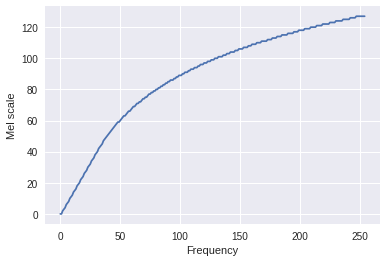

In [0]:
plt.plot(np.argmax(mels, axis=0)[:-2])
plt.xlabel('Frequency')
plt.ylabel('Mel scale')
plt.show()

If we apply the mel transform to all the columns of our spectrogram we get (shockingly) the **mel-spectrogram**, our second set of features. In addition to the frame length and the number of FFT components, there's an additional parameter we can tweak in the mel-spectrogram:

- `n_mels`, the number of filters to use when transforming from frequencies to mels.

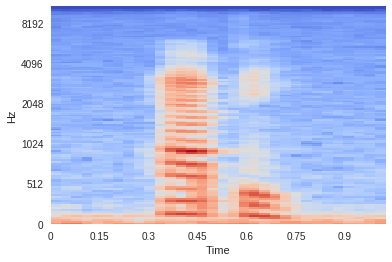

In [0]:
n_mels = 128
melspec = librosa.feature.melspectrogram(y=hm, sr=sr, n_mels=n_mels)
librosa.display.specshow(librosa.power_to_db(melspec), sr=sr, y_axis='mel', x_axis='time')

Mel-spectrograms are good, but there are ways to compress their information even further. To do that we use the _cosine transform_:

$$X_k = \sum_{n=0}^{N-1} x_n \cos\left(\frac{\pi}{N} \left(n + \frac{1}{2} \right) k \right)$$

Which, against all odds, is like the Fourier transform, but without the sines. (In fact we could just as well use the DFT to compress the spectrum -- the reason we normally use DCT is because it deals better with the boundary conditions of typical spectra.)

In the example below we can see how truncating the DCT at higher orders gives a more detailed picture of the original spectrum. These components are usually called _cepstral coefficients_ (origin of the word 'cepstral' is explained below).

Here there's one more parameter to tweak, which in practice is often the most important parameter in ML pre-processing pipelines:

- `n_mfcc`, the number of DCT components to keep.

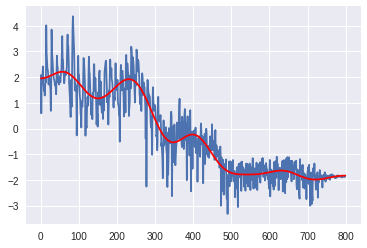

In [10]:
# Extract a section of interest and compute its log spectral power
start = int(0.35*sr)
end = int(0.45*sr)
psd = np.abs(np.fft.fft(hm[start:end]))**2
lpsd = np.log10(psd[0:len(psd)//2])

# The reason we're using the orthonormal normalisation in the dct and
# idct below is to make it easier to ensure that x = idct(dct(x))
n_mfcc = 15
d = dct(lpsd, norm='ortho')[:n_mfcc]
lpsd_approx = idct(d, n=len(lpsd), norm='ortho')
plt.plot(lpsd)
plt.plot(lpsd_approx, 'r')

You can see that just the first few components of the spectrum's DCT reproduce its overall shape quite well.

If, instead of taking the log-spectrum DCT we take the DCT, we're left with another representation of the signal: the _cepstrum_ (bad wordplay on 'spectrum'). Therefore, subsampling a few components of the cepstrum gives us cepstral coefficients.

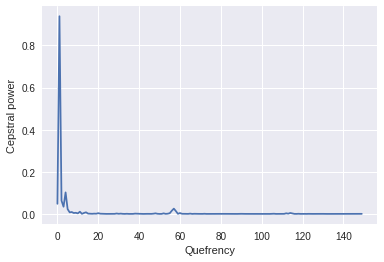

In [0]:
plt.plot(np.abs(ifft(lpsd)[:150])**2)
plt.xlabel('Quefrency')
plt.ylabel('Cepstral power')
plt.show()

If we do this trick for every column in the mel-spectrogram we get our latest and greatest feature set, the **mel-frequency cepstral coefficients** (MFCC). MFCCs are state-of-the-art features for speech processing.

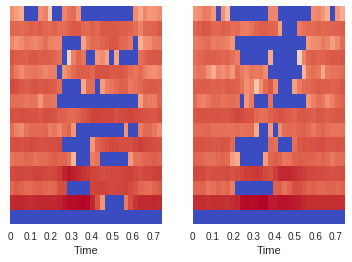

In [0]:
plt.subplot(1,2,1)
melspec = librosa.feature.mfcc(y=ym, sr=sr, n_mfcc=15)
librosa.display.specshow(librosa.power_to_db(melspec), x_axis='time')

plt.subplot(1,2,2)
melspec = librosa.feature.mfcc(y=hm, sr=sr, n_mfcc=15)
librosa.display.specshow(librosa.power_to_db(melspec), x_axis='time')

plt.show()

As a summary, there are four steps involved in calculating the MFCCs of an audio signal:

1. Pick a suitable FFT window size and shift, take the STFT of the signal.
2. Transform the spectrum into mel scale.
3. Take the log of the spectral power.
4. Pick a suitable number of cepstral components, and compute the log-spectrum DCT. That's your MFCC.
5. Launch your RNN start-up.
6. Fame and glory.

## Recurrent models coursework (Unmarked)

This is the last coursework of the Deep Learning class. The main topic is recurrent models, and consists of two parts:

- In **part 1**, you will program your own RNN and your own GRU, and will train them in a multi-class classification problem and compare their performance.

- In **part 2**, you will answer a theoretical (exam-like) question about recurrent models. This will only involve written answers and (possibly) some short mathematical arguments -- no detailed proofs and no programming.

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset:

*   105,829 maximum 1 sec utterances.
*   35 classes, e.g., "yes", "no", "one", "two", "forward", "right", "stop" etc.
*   Around ~1500-4000 samples per class for a total of ~30 hours and 3.3 GBs.
*   Kaggle - [winner](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/46945) achieved ~91% accuracy using ResNet/VGGs on log mel spectrum and other tricks, e.g., ensembling, data augmentation.

We will be working on a small subset of *Speech Commands*:

*   Only 3 classes: "one", "two", "three".
*   Only 11,497 utterances.
*   Faster training - hyperparameter tuning.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

### Part 1: Coding

0. Set-up code and imports

In [0]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

1. Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

2. Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "./data_speech_commands_v0.02/"

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

3. Finish this RNN code (10%)

You are allowed to use nn.Linear.

In [0]:
class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy


4. Finish this GRU code (10%)

You are allowed to use nn.Linear.

In [0]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy


5.

*   Train both on *Speech Commands* for 5 epochs. (10%)
*   Comment on their performance. (10%)



In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()


        if mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return out


6. Modify the RNN code above to make it bidirectional (10%)

In [0]:
class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        pass
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        

7. Configure and instantiate model.

In [0]:
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## If mfcc configuration left unchanged.
# seq_dim = 32
# input_dim = 20

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 1
bias = True

model = RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)
# model = BidirRecurrentModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()

8. Configure optimisation.

In [0]:
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

9. Perform experiment.

In [0]:
loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % 4 == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            correct = 0
            total = 0

            for audio, labels in test_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            t_accuracy = 100 * correct / total
            if accuracy > max_v_accuracy:
                max_v_accuracy = accuracy
                reported_t_accuracy = t_accuracy

            if t_accuracy > max_t_accuracy:
                max_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {} Tmax-Accuracy: {}'.format(iter, loss.item(), accuracy, reported_t_accuracy, max_t_accuracy))


### Part 2: question

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (15%)

b. The following (cartoon) plots show the gradients (as a function of the temporal horizon, a.k.a. sequence length) and the training curves (as a function of training epochs) for three models A, B, and C, trained on the same dataset. (20%)

1. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. Which is which? Why? Please explain your reasoning.

2. For what kinds of problems would you choose each one of these models? 

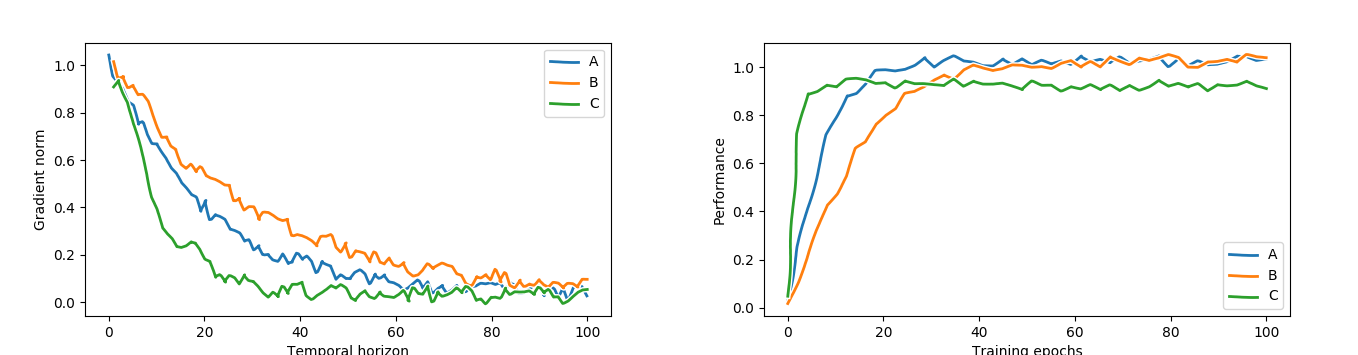

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

c. What is _backpropagation through time_ (BPTT), and when is it used? How is it related to the vanishing and exploding gradients problem from question *a*? What is the effect of the temporal horizon *T*? (15%)